(c) European Space Agency (ESA) - Licensed under  ESA Software Community License Permissive (Type 3) – v2.4

#  Interferogram Generation from BIOMASS L1C Products

The following libraries are required to execute this notebook: `rasterio` (GDAL), `netCDF4`, `numpy`, `scipy`, `matplotlib`, `xml`.  
Tested environments are available for both Windows and Linux.  
For setup support, contact:  
📧 muriel.pinheiro@esa.int / antonio.novelli@ext.esa.int / a.novelli@stariongroup.eu


This notebook processes primary and secondary BIOMASS Level-1C products to compute a  interferogram.  
The workflow includes reading annotation and measurement files, building the complex SAR images, visualising relevant phase screens, and computing the interferogram.

## 🗂️ Index

1. [🌿 Product Initialization and Data Loading](#🌿-product-initialization-and-data-loading)
2. [🍃 flatteningPhasesScreen Visualization](#🍃-flatteningPhasesScreen-visualization)
3. [🌳 Upsampled flatteningPhasesScreen Comparison](#🌳-upsampled-flatteningPhasesScreen-comparison)
4. [🌲 Interferogram and coherence Generation](#🌲-interferogram-and-coherence-generation)


## 🌿 Product Initialization and Data Loading <a name="🌿-product-initialization-and-data-loading"></a>
- Define input paths and load amplitude and phase data from primary and secondary BIOMASS Level-1C products.  
- Read amplitude and phase channels for primary and secondary images.

In [14]:
import xml.etree.ElementTree as ET  
import rasterio
import netCDF4
import numpy as np
import matplotlib.pyplot as plt
import BiomassProduct
import warnings
import numpy.typing as npt
import scipy
from support_functions_l1c import single_baseline_single_pol_coh
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore', category=DeprecationWarning)

In [15]:

path_secondary = r"E:\BIOMASS\02_DATA\AMAZON\OUTPUT_STA\BIO_S1_STA__1S_20250607T103037_20250607T103057_C_G___M___C___T____F002_01_DA3R0D"
path_primary   = r"E:\BIOMASS\02_DATA\AMAZON\OUTPUT_STA\BIO_S1_STA__1S_20250610T103036_20250610T103057_C_G___M___C___T____F002_01_DA3R0P"

product_primary=    BiomassProduct.BiomassProductSTA(path_primary)
product_secondary=  BiomassProduct.BiomassProductSTA(path_secondary)

data_primary_abs =      product_primary.measurement_abs_file   
data_primary_phase =    product_primary.measurement_phase_file   
path_lut_primary =      product_primary.annotation_coregistered_lut_file 
path_main_ann_primary = product_primary.annotation_coregistered_xml_file 

data_secondary_abs =         product_secondary.measurement_abs_file 
data_secondary_phase =       product_secondary.measurement_phase_file  
path_lut_coregistered =      product_secondary.annotation_coregistered_lut_file 
path_main_ann_coregistered = product_secondary.annotation_coregistered_xml_file 

print("\n[INFO] PRIMARY PRODUCT:")
print(f"  - MEASUREMENT ABS      : {data_primary_abs}")
print(f"  - MEASUREMENT PHASE    : {data_primary_phase}")
print(f"  - LUT (COREG)          : {path_lut_primary}")
print(f"  - ANNOTATION XML       : {path_main_ann_primary}")

print("\n[INFO] SECONDARY PRODUCT:")
print(f"  - MEASUREMENT ABS      : {data_secondary_abs}")
print(f"  - MEASUREMENT PHASE    : {data_secondary_phase}")
print(f"  - LUT (COREG)          : {path_lut_coregistered}")
print(f"  - ANNOTATION XML       : {path_main_ann_coregistered}")

Could not load variables from group 'skpPhaseCalibration': [Errno group not found: skpPhaseCalibration] 'skpPhaseCalibration'
Could not load variables from group 'fastIonosphereRemoval': [Errno group not found: fastIonosphereRemoval] 'fastIonosphereRemoval'
All available LUT variables loaded as attributes.
Could not load variables from group 'skpPhaseCalibration': [Errno group not found: skpPhaseCalibration] 'skpPhaseCalibration'
Could not load variables from group 'fastIonosphereRemoval': [Errno group not found: fastIonosphereRemoval] 'fastIonosphereRemoval'
All available LUT variables loaded as attributes.

[INFO] PRIMARY PRODUCT:
  - MEASUREMENT ABS      : E:\BIOMASS\02_DATA\AMAZON\OUTPUT_STA\BIO_S1_STA__1S_20250610T103036_20250610T103057_C_G___M___C___T____F002_01_DA3R0P\measurement\bio_s1_sta__1s_20250610t103036_20250610t103057_c_g___m___c___t____f002_i_abs.tiff
  - MEASUREMENT PHASE    : E:\BIOMASS\02_DATA\AMAZON\OUTPUT_STA\BIO_S1_STA__1S_20250610T103036_20250610T103057_C_G___M__

In [16]:
nan_value = -9999
with rasterio.open(data_primary_abs) as amp_raster_pri: #get the amp channels
    amp_hh_pri = amp_raster_pri.read(1) #nupy.ndarray object
    amp_hh_pri = np.ma.masked_equal(amp_hh_pri, nan_value)
        

with rasterio.open(data_primary_phase) as phase_hh_pri: #get the phase channels
    phase_hh_pri = phase_hh_pri.read(1) #nupy.ndarray object
    phase_hh_pri = np.ma.masked_equal(phase_hh_pri, nan_value)
  

with rasterio.open(data_secondary_abs) as amp_raster_sec: #get the amp channels
    amp_hh_sec = amp_raster_sec.read(1) #nupy.ndarray object
    amp_hh_sec = np.ma.masked_equal(amp_hh_sec, nan_value)

with rasterio.open(data_secondary_phase) as phase_hh_sec: #get the phase channels
    phase_hh_sec = phase_hh_sec.read(1) #nupy.ndarray object
    phase_hh_sec = np.ma.masked_equal(phase_hh_sec, nan_value)

# Print stats
print("\n[INFO] PRIMARY PRODUCT:")
print(f"  - Max amplitude (HH): {np.max(amp_hh_pri)}")
print(f"  - Max phase (HH):     {np.max(phase_hh_pri)}")
print("\n[INFO] SECONDARY PRODUCT:")
print(f"  - Max amplitude (HH): {np.max(amp_hh_sec)}")
print(f"  - Max phase (HH):     {np.max(phase_hh_sec)}")


[INFO] PRIMARY PRODUCT:
  - Max amplitude (HH): 31.105731964111328
  - Max phase (HH):     3.141592264175415

[INFO] SECONDARY PRODUCT:
  - Max amplitude (HH): 30.22762107849121
  - Max phase (HH):     3.1415927410125732


In [17]:
# Combine amplitude and phase to form the complex SAR images for both acquisitions.
# These complex-valued arrays will be used in the interferogram generation step.

primary = (amp_hh_pri * np.exp(1j * phase_hh_pri)).astype(np.complex64)
secondary = (amp_hh_sec * np.exp(1j * phase_hh_sec)).astype(np.complex64)

In [18]:
#####read the luts
lut_co = netCDF4.Dataset(path_lut_coregistered)
lut_pri = netCDF4.Dataset(path_lut_primary)

#####get the lut axis
relativeAzimuthTime_pri = np.array(lut_pri['relativeAzimuthTime']).astype(np.float64)
slantRangeTime_pri = np.array(lut_pri['slantRangeTime']).astype(np.float64)

lut_az_axes_pri = (relativeAzimuthTime_pri - relativeAzimuthTime_pri[0]).astype(np.float64)
lut_range_axis_pri = slantRangeTime_pri - slantRangeTime_pri[0]

#####parse the main annotation
main_ann_primary = ET.parse(path_main_ann_primary)
main_ann_primary_root = main_ann_primary.getroot()

####get the data from the main annotations (primary and coregistered slc (L1C))

sarImage_pri = main_ann_primary_root.findall('sarImage')
#range coreg
firstSampleSlantRangeTime_pri = np.float64(sarImage_pri[0].findall("firstSampleSlantRangeTime")[0].text)
rangeTimeInterval_pri = np.float64(sarImage_pri[0].findall("rangeTimeInterval")[0].text)
numberOfSamples_pri = np.int64(sarImage_pri[0].findall("numberOfSamples")[0].text)

#az coreg
azimuthTimeInterval_pri = np.float64(sarImage_pri[0].findall("azimuthTimeInterval")[0].text)
firstLineAzimuthTime_pri = np.datetime64(sarImage_pri[0].findall("firstLineAzimuthTime")[0].text)
numberOfLines_pri = np.int64(sarImage_pri[0].findall("numberOfLines")[0].text)

######################## as per STA_P
#primary az axis
axis = 0
roi_pri =  [0, 0,numberOfLines_pri, numberOfSamples_pri]
time_step_pri = azimuthTimeInterval_pri
time_start_pri = 0
az_slc_axis_pri_stac = np.arange(roi_pri[axis + 2], dtype=np.float64) * time_step_pri

#pri rg axis
axis = 1
roi_pri =  [0, 0,numberOfLines_pri, numberOfSamples_pri]
time_step_pri = rangeTimeInterval_pri
time_start_pri = firstSampleSlantRangeTime_pri
range_slc_axis_pri_stac = np.arange(roi_pri[axis + 2], dtype=np.float64) * time_step_pri

print("\n[INFO] SLC Primary Range Axis:")
print(f"  - Number of samples : {numberOfSamples_pri}")
print(f"  - Range spacing     : {rangeTimeInterval_pri} seconds")
print(f"  - Max range axis    : {np.max(range_slc_axis_pri_stac):.6f} seconds")


[INFO] SLC Primary Range Axis:
  - Number of samples : 1368
  - Range spacing     : 1.32183907894041e-07 seconds
  - Max range axis    : 0.000181 seconds


## 🍃 flatteningPhasesScreen Visualization  <a name="🍃-flatteningPhasesScreen-visualization"></a>
- Compute masked mean and standard deviation for flattening phase screens.  
- Visualize primary and coregistered phase screens side-by-side using consistent color scale.

In [19]:
#get the flatteningPhasesScreen
lut_co = netCDF4.Dataset(path_lut_coregistered)
flatteningPhasesScreen_co = np.array(lut_co.groups['coregistration']['flatteningPhasesScreen']).astype(np.float64)
lut_pri = netCDF4.Dataset(path_lut_primary)
flatteningPhasesScreen_pri = np.array(lut_pri.groups['coregistration']['flatteningPhasesScreen']).astype(np.float64)

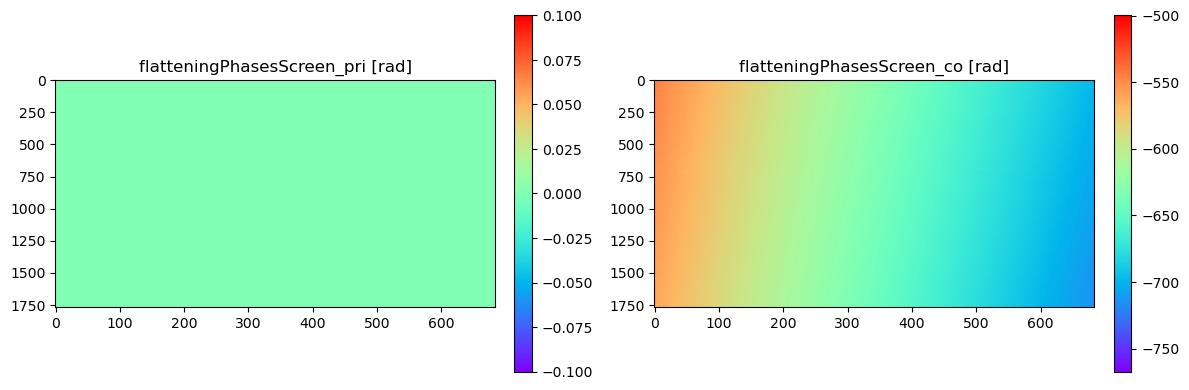

In [20]:
flatteningPhasesScreen_pri_avg = np.mean(np.ma.masked_equal(flatteningPhasesScreen_pri,-9999))
flatteningPhasesScreen_pri_std = np.std(np.ma.masked_equal(flatteningPhasesScreen_pri, -9999))

flatteningPhasesScreen_co_avg = np.mean(np.ma.masked_equal(flatteningPhasesScreen_co,-9999))
flatteningPhasesScreen_co_std = np.std(np.ma.masked_equal(flatteningPhasesScreen_co, -9999))


# Parametri condivisi
nan_value = 255
std_multiplier = 3
aspect_ratio = 0.2
colorbar_fraction = 0.05
colorbar_pad = 0.04

# Maschera dei valori -9999
masked_pri = np.ma.masked_equal(flatteningPhasesScreen_pri, -9999)
masked_co = np.ma.masked_equal(flatteningPhasesScreen_co, -9999)

# Media e deviazione standard
avg_pri = np.mean(masked_pri)
std_pri = np.std(masked_pri)

avg_co = np.mean(masked_co)
std_co = np.std(masked_co)

# Plot affiancati
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# PRIMARY
im1 = axs[0].imshow(
    masked_pri,
    cmap="rainbow",
    aspect=aspect_ratio,
    interpolation="none",
    vmin=avg_pri - std_multiplier * std_pri,
    vmax=avg_pri + std_multiplier * std_pri
)
axs[0].set_title("flatteningPhasesScreen_pri [rad]")
cbar1 = fig.colorbar(im1, ax=axs[0], orientation='vertical', fraction=colorbar_fraction, pad=colorbar_pad)

# CORE
im2 = axs[1].imshow(
    masked_co,
    cmap="rainbow",
    aspect=aspect_ratio,
    interpolation="none",
    vmin=avg_co - std_multiplier * std_co,
    vmax=avg_co + std_multiplier * std_co
)
axs[1].set_title("flatteningPhasesScreen_co [rad]")
cbar2 = fig.colorbar(im2, ax=axs[1], orientation='vertical', fraction=colorbar_fraction, pad=colorbar_pad)

fig.tight_layout()
plt.show()

---

## 🌳 Upsampled flatteningPhasesScreen Comparison <a name="🌳-upsampled-flatteningPhasesScreen-comparison"></a>
- Display upsampled versions of the flattening phase screens.  
- Use improved visualization layout for direct comparison between primary and secondary acquisitions.

---

In [21]:
#preparation of the interpolators
axes_in = (lut_az_axes_pri, lut_range_axis_pri) # as showed before you can use also the *co axes since they are equal as expteced 
axes_out = (az_slc_axis_pri_stac, range_slc_axis_pri_stac) # as showed before you can use also the *co axes since they are equal as expteced 
degree_x = 1
degree_y = 1
smoother = 0.0
bbox=[
            min(np.min(axes_in[0]), np.min(axes_out[0])),
            max(np.max(axes_in[0]), np.max(axes_out[0])),
            max(np.min(axes_in[1]), np.min(axes_out[1])),
            max(np.max(axes_in[1]), np.max(axes_out[1])),
        ]

flatteningPhasesScreen_co_interpolator = scipy.interpolate.RectBivariateSpline(    
        axes_in[0],
        axes_in[1],
        flatteningPhasesScreen_co,
        bbox= bbox,
    kx=degree_x,
        ky=degree_y,
        s=smoother
     )

flatteningPhasesScreen_pri_interpolator = scipy.interpolate.RectBivariateSpline(    
        axes_in[0],
        axes_in[1],
        flatteningPhasesScreen_pri,
        bbox= bbox,
    kx=degree_x,
        ky=degree_y,
        s=smoother
     )

In [22]:

flatteningPhasesScreen_co_upsampled = flatteningPhasesScreen_co_interpolator(axes_out[0], axes_out[1])
flatteningPhasesScreen_pri_upsampled = flatteningPhasesScreen_pri_interpolator(axes_out[0], axes_out[1])
flatteningPhasesScreen_avg = np.mean(np.ma.masked_equal(flatteningPhasesScreen_pri_upsampled,-9999))
flatteningPhasesScreen_std = np.std(np.ma.masked_equal(flatteningPhasesScreen_pri_upsampled, -9999))
flatteningPhasesScreen_avg = np.mean(np.ma.masked_equal(flatteningPhasesScreen_co_upsampled,-9999))
flatteningPhasesScreen_std = np.std(np.ma.masked_equal(flatteningPhasesScreen_co_upsampled, -9999))


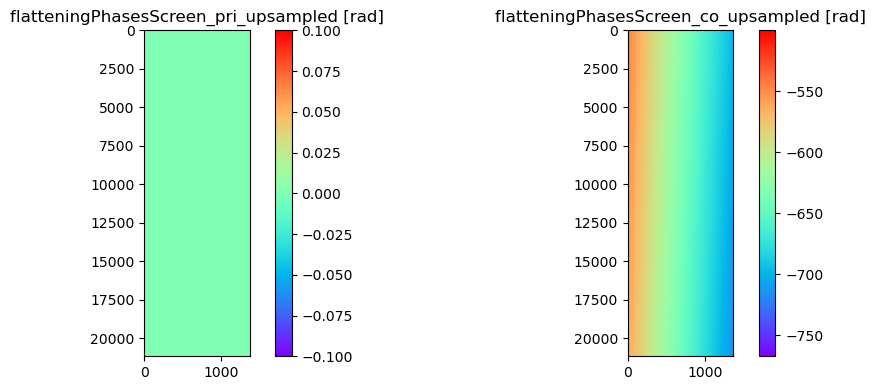

In [23]:


# Parametri condivisi
nan_value = 255
std_multiplier = 3
aspect_ratio = 0.2
colorbar_fraction = 0.05
colorbar_pad = 0.04

# Maschera dei valori -9999
masked_pri_up = np.ma.masked_equal(flatteningPhasesScreen_pri_upsampled, -9999)
masked_co_up = np.ma.masked_equal(flatteningPhasesScreen_co_upsampled, -9999)

# Media e deviazione standard
avg_pri_up = np.mean(masked_pri_up)
std_pri_up = np.std(masked_pri_up)

avg_co_up = np.mean(masked_co_up)
std_co_up = np.std(masked_co_up)

# Plot affiancati
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# PRIMARY UPSAMPLED
im1 = axs[0].imshow(
    masked_pri_up,
    cmap="rainbow",
    aspect=aspect_ratio,
    interpolation="none",
    vmin=avg_pri_up - std_multiplier * std_pri_up,
    vmax=avg_pri_up + std_multiplier * std_pri_up
)
axs[0].set_title("flatteningPhasesScreen_pri_upsampled [rad]")
fig.colorbar(im1, ax=axs[0], orientation='vertical', fraction=colorbar_fraction, pad=colorbar_pad)

# CORE UPSAMPLED
im2 = axs[1].imshow(
    masked_co_up,
    cmap="rainbow",
    aspect=aspect_ratio,
    interpolation="none",
    vmin=avg_co_up - std_multiplier * std_co_up,
    vmax=avg_co_up + std_multiplier * std_co_up
)
axs[1].set_title("flatteningPhasesScreen_co_upsampled [rad]")
fig.colorbar(im2, ax=axs[1], orientation='vertical', fraction=colorbar_fraction, pad=colorbar_pad)

fig.tight_layout()
plt.show()


## 🌲 Interferogram Generation <a name="🌲-interferogram-generation"></a>
 
- Generate interferogram and coherence maps.

In [24]:
flatteningPhasesScreen_pri_upsampled.min()
flatteningPhasesScreen_pri_upsampled.max()
#interferogram = primary * np.conj(secondary*np.exp(-1j * np.mean(flatteningPhasesScreen_co_upsampled)))
interferogram = primary * np.conj(secondary)

interferogram = primary * np.conj(secondary)
interferogram_flat =( primary* np.exp(1j * flatteningPhasesScreen_pri_upsampled)) * (np.conj(secondary*np.exp(1j * flatteningPhasesScreen_co_upsampled)))

#interferogram_flat = (primary*np.exp(1j*flatteningPhasesScreen_pri_upsampled)) * (np.conj(secondary*np.exp(1j * flatteningPhasesScreen_co_upsampled)))

#interferogram_flat = primary * (np.conj(secondary*np.exp(1j * (flatteningPhasesScreen_pri_upsampled-flatteningPhasesScreen_co_upsampled))))

coh = single_baseline_single_pol_coh(
    primary,
    secondary*np.exp(1j * (flatteningPhasesScreen_co_upsampled -flatteningPhasesScreen_pri_upsampled)),
    (5,5))

print(np.min(coh))
print(np.max(coh))

phase_deg = np.angle(interferogram, deg=True)
phase_flat_deg = np.angle(interferogram_flat, deg=True)

(-0.996782758098022+0.03691340428171922j)
(0.9846651401048535+0.020452605925508915j)


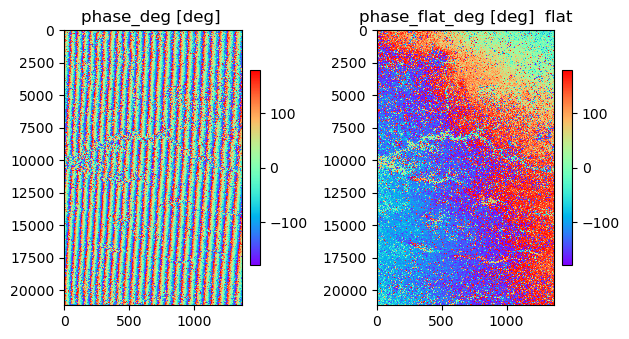

In [25]:

std_multiplier = 3 
aspect_ratio = 0.1
colorbar_fraction = 0.05
colorbar_pad = 0.04

fig, axes = plt.subplots(1,2) 

ax2 = axes[0].imshow( 
    phase_deg , 
    cmap='rainbow',
    aspect=aspect_ratio,
    vmin = -180 ,#vmin =  interferogram_xx_avg - std_multiplier* interferogram_xx_std,
    vmax =  180, #vmax =  interferogram_xx_avg + std_multiplier* interferogram_xx_std,
    interpolation="nearest"
)
axes[0].set_title('phase_deg [deg] ')


ax5 = axes[1].imshow( 
    phase_flat_deg, 
    cmap='rainbow',
    aspect=aspect_ratio,
    vmin = -180 ,#vmin =  interferogram_xx_with_screens_avg - std_multiplier* interferogram_xx_with_screens_std,
    vmax =  180, # vmax =  interferogram_xx_with_screens_avg + std_multiplier* interferogram_xx_with_screens_std,
    interpolation="nearest"
)
axes[1].set_title('phase_flat_deg [deg]  flat')
fig.colorbar(ax2, ax=axes[0], orientation='vertical', fraction=colorbar_fraction, pad=colorbar_pad)
fig.colorbar(ax5, ax=axes[1], orientation='vertical', fraction=colorbar_fraction, pad=colorbar_pad)
fig.tight_layout()

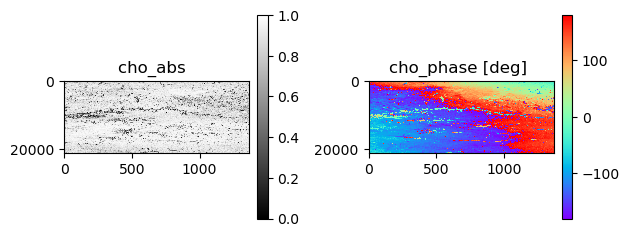

In [26]:
coh_abs = np.abs(coh)
coh_phase = np.angle(coh, deg=True)

std_multiplier = 3 
aspect_ratio = 0.025
colorbar_fraction = 0.05
colorbar_pad = 0.04

fig, axes = plt.subplots(1,2) 

ax2 = axes[0].imshow( 
    coh_abs , 
    cmap='gray',
    aspect=aspect_ratio,
    vmin = 0 ,#vmin =  interferogram_xx_avg - std_multiplier* interferogram_xx_std,
    vmax =  1, #vmax =  interferogram_xx_avg + std_multiplier* interferogram_xx_std,
    interpolation="nearest"
)
axes[0].set_title('cho_abs  ')


ax5 = axes[1].imshow( 
    coh_phase, 
    cmap='rainbow',
    aspect=aspect_ratio,
    vmin = -180 ,#vmin =  interferogram_xx_with_screens_avg - std_multiplier* interferogram_xx_with_screens_std,
    vmax =  180, # vmax =  interferogram_xx_with_screens_avg + std_multiplier* interferogram_xx_with_screens_std,
    interpolation="nearest"
)
axes[1].set_title('cho_phase [deg] ')
fig.colorbar(ax2, ax=axes[0], orientation='vertical', fraction=colorbar_fraction, pad=colorbar_pad)
fig.colorbar(ax5, ax=axes[1], orientation='vertical', fraction=colorbar_fraction, pad=colorbar_pad)   
fig.tight_layout()